<font color = blue><font size = 6> HDLSTM(Trend) </font></font><br>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [24]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [25]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [26]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [27]:
class Trend_Encoder(nn.Module):
    def __init__(self,configs):
        super(Trend_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [28]:
class Trend_Decoder(nn.Module):
    def __init__(self,configs):
        super(Trend_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [29]:
tup= (1,2)
len(tup)

2

In [30]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [31]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [32]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.trend_encoder = Trend_Encoder(configs)
        self.trend_decoder = Trend_Decoder(configs)
        
        self.Linear_Seasonal = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        div_factor = x[:,-1,:].view(-1,1,1)
        x = x/div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.permute(0,2,1).to(self.device) 

        _,final_trend_hidden = self.trend_encoder(trend_init)
        trend_output,_ = self.trend_decoder(x = trend_init[:,-1,:].view(-1,1,1),encoder_hidden = final_trend_hidden)
        season_output = self.Linear_Seasonal(seasonal_init)
        
        output = (trend_output+season_output)*div_factor
        
        return output,season_output,trend_output

In [33]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [34]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [35]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [36]:
target

tensor([[[22.0614]],

        [[22.0653]],

        [[22.0655]],

        ...,

        [[22.4421]],

        [[22.4284]],

        [[22.4296]]], device='cuda:0')

In [37]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [38]:
torch.manual_seed(42)

In [39]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [40]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 5.920025307917627 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 0.3331561094457665 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 0.31013406681071165 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 0.2900492368920908 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 0.27303367379844484 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 0.27259236541869425 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 0.3129882976883881 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 0.3498354220860883 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 0.31022052512924886 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 0.3490687191485678 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 0.3061051056747548 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 0.336862054645977 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 0.2629360778336223

In [41]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.03447338486546414 %
SMAPE 0.008260873308714167 %
SMAPE 0.04864998571201795 %
SMAPE 0.0036102822248835764 %
SMAPE 0.01303414550151416 %
SMAPE 0.00103999335624394 %
SMAPE 0.0052626901811265725 %
SMAPE 0.00174506223612525 %
SMAPE 0.009233730776202265 %
SMAPE 0.0008497685403483501 %
SMAPE 0.03628330281230774 %
SMAPE 0.013907643227213386 %
SMAPE 0.011650930014930339 %
SMAPE 0.008325178106900921 %
SMAPE 0.08403487819191469 %
SMAPE 0.025895930764079367 %
SMAPE 0.04158948386850625 %
SMAPE 0.023805762050812973 %
SMAPE 0.027528945918220415 %
SMAPE 0.00456455393015176 %
SMAPE 0.006836812299852112 %
SMAPE 0.051822204197264916 %
SMAPE 0.05083120926065021 %
SMAPE 0.0015982087602424144 %
SMAPE 0.02712037624974073 %
SMAPE 0.003641255294226653 %
SMAPE 0.020793524742373393 %
SMAPE 0.06785613469060081 %
SMAPE 0.10672407260426553 %
SMAPE 0.2255844385417731 %
SMAPE 0.014096479543184158 %
SMAPE 0.004543732742504858 %
SMAPE 0.0029308430113133 %
SMAPE 0.003286168616341456 %
SMAPE 0.003112701087054859 

SMAPE 0.0462127750407717 %
SMAPE 0.0007365155871639217 %
SMAPE 0.0034010094301493154 %
SMAPE 0.020536241356012397 %
SMAPE 0.00493129164113526 %
SMAPE 0.0022533088177851823 %
SMAPE 0.002432953792983028 %
SMAPE 0.002392859987395468 %
SMAPE 0.006311015721678359 %
SMAPE 0.0032084054163945552 %
SMAPE 0.005752607525806752 %
SMAPE 0.003276696512784838 %
SMAPE 0.006432831392658045 %
SMAPE 0.0006957652795733793 %
SMAPE 0.0025036602891788107 %
SMAPE 0.0014723077424250164 %
SMAPE 0.0058287066480460226 %
SMAPE 0.0052317410982638535 %
SMAPE 0.002008858543661063 %
SMAPE 0.010039540175057482 %
SMAPE 0.02045775700733543 %
SMAPE 0.003422407581808784 %
SMAPE 0.018899354932990775 %
SMAPE 0.002649930791562838 %
SMAPE 0.030793249932230538 %
SMAPE 0.025932952803600532 %
SMAPE 0.009166929415613367 %
SMAPE 0.0007378234735000433 %
SMAPE 0.015892295603066486 %
SMAPE 0.00838152577776441 %
SMAPE 0.05577400627623775 %
SMAPE 0.04371938205541426 %
SMAPE 0.008332217957160992 %
SMAPE 0.006900679987431602 %
SMAPE 0.003

SMAPE 0.019643132697126475 %
SMAPE 0.02925771451361925 %
SMAPE 0.03134146345348654 %
SMAPE 0.010398854963803217 %
SMAPE 0.0208177853797622 %
SMAPE 0.0020892691746610126 %
SMAPE 0.02701857542638919 %
SMAPE 0.0285146016027511 %
SMAPE 0.00045534122864410165 %
SMAPE 0.003049692914856905 %
SMAPE 0.002292220179860749 %
SMAPE 0.0309037020699634 %
SMAPE 0.008025298477349452 %
SMAPE 0.003018751657847929 %
SMAPE 0.003830325457442996 %
SMAPE 0.01121210925796845 %
SMAPE 0.003508538332596345 %
SMAPE 0.02598424924505594 %
SMAPE 0.00583918549085638 %
SMAPE 0.01684177017057209 %
SMAPE 0.005910401949392963 %
SMAPE 0.012122874427348052 %
SMAPE 0.0026520190994858694 %
SMAPE 0.015658037356047316 %
SMAPE 0.008496669045989336 %
SMAPE 0.02813192813390941 %
SMAPE 0.008956008251679748 %
SMAPE 0.0028189784933942974 %
SMAPE 0.012855748636091846 %
SMAPE 0.010681567737805153 %
SMAPE 0.00912411382597611 %
SMAPE 0.008608837128008417 %
SMAPE 0.0025307300641870256 %
SMAPE 0.0022882421604393244 %
SMAPE 0.00793253818690

SMAPE 0.0012572504713830313 %
SMAPE 0.0009664053976763398 %
SMAPE 0.0055883591570733415 %
SMAPE 0.0041851736096489844 %
SMAPE 0.018271337206442695 %
SMAPE 0.014746332603763792 %
SMAPE 0.014909664344259 %
SMAPE 0.01758934377426158 %
SMAPE 0.05145452231022318 %
SMAPE 0.02589645667512741 %
SMAPE 0.026905750577668645 %
SMAPE 0.029960110233503204 %
SMAPE 0.003053299238274576 %
SMAPE 0.000614859544441515 %
SMAPE 0.00459294365876417 %
SMAPE 0.003797070926935931 %
SMAPE 0.0035672497792091917 %
SMAPE 0.0035110865561165387 %
SMAPE 0.004825136662816476 %
SMAPE 0.022270180911732496 %
SMAPE 0.007666092357638377 %
SMAPE 0.001232416996671759 %
SMAPE 0.014941669316769435 %
SMAPE 0.009510428102004198 %
SMAPE 0.005016865112914104 %
SMAPE 0.027210712280862026 %
SMAPE 0.004972867321576757 %
SMAPE 0.0072801493011525045 %
SMAPE 0.017767308272482296 %
SMAPE 0.03878745009951956 %
SMAPE 0.015702859002516334 %
SMAPE 0.0011577556285686796 %
SMAPE 0.00687888508036849 %
SMAPE 0.0229048811531527 %
SMAPE 0.012265732

SMAPE 0.00330812807389691 %
SMAPE 0.020266743145768373 %
SMAPE 0.005758331637281344 %
SMAPE 0.03310812178494871 %
SMAPE 0.041693689946924906 %
SMAPE 0.020214382865546554 %
SMAPE 0.009554426338922895 %
SMAPE 0.01441006117548227 %
SMAPE 0.005990002851859799 %
SMAPE 0.01781827153155291 %
SMAPE 0.025745272970425507 %
SMAPE 0.017286706656932438 %
SMAPE 0.031305556024719294 %
SMAPE 0.002025459499606086 %
SMAPE 0.005054813113488876 %
SMAPE 0.03269058357506083 %
SMAPE 0.012822026703851463 %
SMAPE 0.03628456303167127 %
SMAPE 0.005274906305508864 %
SMAPE 0.003953553864718629 %
SMAPE 0.01249764211590332 %
SMAPE 0.00588801792389404 %
SMAPE 0.0024789305281842644 %
SMAPE 0.0021396605011716474 %
SMAPE 0.002138844311140531 %
SMAPE 0.0012288364378889582 %
SMAPE 0.028643709508514803 %
SMAPE 0.001055313970816485 %
SMAPE 0.012070850510468745 %
SMAPE 0.012358603264146948 %
SMAPE 0.018469624850695254 %
SMAPE 0.007796586070867306 %
SMAPE 0.04710973480592884 %
SMAPE 0.0108877782318757 %
SMAPE 0.00749312014028

SMAPE 0.0043362842926057965 %
SMAPE 0.00252923796344362 %
SMAPE 0.004297694544248998 %
SMAPE 0.03366221856344964 %
SMAPE 0.02657192243555073 %
SMAPE 0.005287586896201901 %
SMAPE 0.01032818156690496 %
SMAPE 0.007378192853209954 %
SMAPE 0.008676790927836464 %
SMAPE 0.012622056364136824 %
SMAPE 0.06843822661795684 %
SMAPE 0.03754033208707597 %
SMAPE 0.0008537583679952832 %
SMAPE 0.0040536588307134025 %
SMAPE 0.01599049095528926 %
SMAPE 0.01487432745423689 %
SMAPE 0.04290643176847908 %
SMAPE 0.027120020102444187 %
SMAPE 0.00979230349298632 %
SMAPE 0.03500047742117829 %
SMAPE 0.030404398025069668 %
SMAPE 0.03342172832606849 %
SMAPE 0.0006452960961667031 %
SMAPE 0.0028314586833602107 %
SMAPE 0.0023864984272279344 %
SMAPE 0.0020115744535331714 %
SMAPE 0.00945688994829652 %
SMAPE 0.014383196827793654 %
SMAPE 0.008284378225425826 %
SMAPE 0.0023425143320991992 %
SMAPE 0.019072820848947458 %
SMAPE 0.0020525045427604027 %
SMAPE 0.006777518966202933 %
SMAPE 0.017349823659138508 %
SMAPE 0.0020492763

SMAPE 0.0039424597325279365 %
SMAPE 0.034802143587434387 %
SMAPE 0.015507630228967173 %
SMAPE 0.02456622407398612 %
SMAPE 0.001203803545251958 %
SMAPE 0.0005254855638270328 %
SMAPE 0.00191983700142373 %
SMAPE 0.0031348953881575876 %
SMAPE 0.015552186349751196 %
SMAPE 0.02444121901049812 %
SMAPE 0.04313356983959693 %
SMAPE 0.008427682598153297 %
SMAPE 0.014462532234205128 %
SMAPE 0.023793168016709387 %
SMAPE 0.01205863813538599 %
SMAPE 0.009754472979814466 %
SMAPE 0.0032143914509674687 %
SMAPE 0.0040333998875894395 %
SMAPE 0.006103506732642927 %
SMAPE 0.013609672404768958 %
SMAPE 0.0010871078421956781 %
SMAPE 0.0027929430838469216 %
SMAPE 0.0057845994795115985 %
SMAPE 0.016386033344446105 %
SMAPE 0.00456747369825905 %
SMAPE 0.015789784798286632 %
SMAPE 0.0018872432093886007 %
SMAPE 0.0013497153329922185 %
SMAPE 0.028810429249432445 %
SMAPE 0.0014097305507334568 %
SMAPE 0.009765827294643259 %
SMAPE 0.014321243942134744 %
SMAPE 0.03563293288823388 %
SMAPE 0.012717347978536965 %
SMAPE 0.01

SMAPE 0.021605352495313923 %
SMAPE 0.015972648909638565 %
SMAPE 0.0094479120118649 %
SMAPE 0.00899022380147585 %
SMAPE 0.02525542172332251 %
SMAPE 0.007394258396800524 %
SMAPE 0.003319984692097932 %
SMAPE 0.009377613731224699 %
SMAPE 0.0005339575204885705 %
SMAPE 0.003724745451961553 %
SMAPE 0.031318212498263165 %
SMAPE 0.001666981541717405 %
SMAPE 0.029501649877659016 %
SMAPE 0.014427884851045292 %
SMAPE 0.011551644078778622 %
SMAPE 0.013375921033457416 %
SMAPE 0.0077480418392497094 %
SMAPE 0.002015246958762873 %
SMAPE 0.025688952310702003 %
SMAPE 0.03523608526734279 %
SMAPE 0.009479001486624838 %
SMAPE 0.0066357093357822805 %
SMAPE 0.0038641321394763395 %
SMAPE 0.012376454104469305 %
SMAPE 0.004469240300977617 %
SMAPE 0.0016400037361137265 %
SMAPE 0.004606350361484601 %
SMAPE 0.001154539325824544 %
SMAPE 0.0004909932349335122 %
SMAPE 0.001792450954091862 %
SMAPE 0.00896520832169756 %
SMAPE 0.013877803988677329 %
SMAPE 0.0020215629059663343 %
SMAPE 0.0053324372319139 %
SMAPE 0.0034791

SMAPE 0.034105705819911236 %
SMAPE 0.014815825354958179 %
SMAPE 0.01639802243884958 %
SMAPE 0.03323082019841905 %
SMAPE 0.01838799065746599 %
SMAPE 0.023571905997911813 %
SMAPE 0.010374986365889072 %
SMAPE 0.007238689599148529 %
SMAPE 0.059945268791352646 %
SMAPE 0.02667630107202967 %
SMAPE 0.06198736325586651 %
SMAPE 0.006386635496284042 %
SMAPE 0.04624455691578788 %
SMAPE 0.0173959659230718 %
SMAPE 0.04474486060760796 %
SMAPE 0.04583745788335136 %
SMAPE 0.014717498923999983 %
SMAPE 0.012294385877737568 %
SMAPE 0.08818244296367084 %
SMAPE 0.02752402710029855 %
SMAPE 0.0577923775234126 %
SMAPE 0.07370786769089932 %
SMAPE 0.00658578056343373 %
SMAPE 0.010703673139886405 %
SMAPE 0.008013408303838787 %
SMAPE 0.023244470007341533 %
SMAPE 0.01194384516008995 %
SMAPE 0.023340221471471523 %
SMAPE 0.0019352190786321444 %
SMAPE 0.033499892524616826 %
SMAPE 0.001010733293639987 %
SMAPE 0.06491305563503147 %
SMAPE 0.12024271704081002 %
SMAPE 0.0007151075913043314 %
SMAPE 0.0010933497715654994 %
S

SMAPE 0.03089788322745335 %
SMAPE 0.005865556485233014 %
SMAPE 0.002589780356586857 %
SMAPE 0.004032032918757977 %
SMAPE 0.0031307748840703194 %
SMAPE 0.014280997048288668 %
SMAPE 0.023299550534829905 %
SMAPE 0.04064061553827969 %
SMAPE 0.0016335811758523278 %
SMAPE 0.04271105574191836 %
SMAPE 0.028992659109704277 %
SMAPE 0.03960479172840792 %
SMAPE 0.027084688830200324 %
SMAPE 0.01285871341389111 %
SMAPE 0.012409392330482662 %
SMAPE 0.003924825461396608 %
SMAPE 0.00792839790579336 %
SMAPE 0.04160576526936666 %
SMAPE 0.012566556319228537 %
SMAPE 0.0007100501499763823 %
SMAPE 0.0016515568950126183 %
SMAPE 0.009279598008085088 %
SMAPE 0.009024543005779151 %
SMAPE 0.02048137486315227 %
SMAPE 0.002758788773718379 %
SMAPE 0.007738626634704814 %
SMAPE 0.0036829254304819865 %
SMAPE 0.0035857771753171623 %
SMAPE 0.0074267193106862806 %
SMAPE 0.00632354459277451 %
SMAPE 0.011284110225631139 %
SMAPE 0.03727474573264544 %
SMAPE 0.0021867848490515485 %
SMAPE 0.004614580181844019 %
SMAPE 0.00691673

SMAPE 3.2985051795840263 %
SMAPE 4.544313430786133 %
SMAPE 8.76253841817379 %
SMAPE 5.794785011559725 %
SMAPE 3.997403867542744 %
SMAPE 2.4613552130758762 %
SMAPE 2.0834344793111086 %
SMAPE 0.12342739267398883 %
SMAPE 0.01858987618760466 %
SMAPE 1.024388483259827 %
SMAPE 0.7989890449680388 %
SMAPE 1.6782889738678932 %
SMAPE 0.9254678473807872 %
SMAPE 0.1027331148978874 %
SMAPE 0.780437455046922 %
SMAPE 0.021756521924771732 %
SMAPE 0.6475979331880808 %
SMAPE 1.439189873635769 %
SMAPE 1.6085795471444726 %
SMAPE 0.7902285777963697 %
SMAPE 0.19300033333456668 %
SMAPE 0.02775486997768439 %
SMAPE 0.03805376568698193 %
SMAPE 0.07321812565675145 %
SMAPE 0.09016871247536073 %
SMAPE 1.64666464086622 %
SMAPE 1.9505426902323961 %
SMAPE 2.508315047249198 %
SMAPE 0.07022672664015772 %
SMAPE 0.27164715128719763 %
SMAPE 0.01393630846249039 %
SMAPE 1.4222669815644622 %
SMAPE 1.5400762725621462 %
SMAPE 2.9576845224946737 %
SMAPE 1.6478333435952663 %
SMAPE 1.4798943037167192 %
SMAPE 1.0287380465306342 %


SMAPE 0.17865080631736419 %
SMAPE 0.18677485391708615 %
SMAPE 0.004574932528996101 %
SMAPE 0.03547280777024753 %
SMAPE 0.5042355583282188 %
SMAPE 0.08078422395055895 %
SMAPE 1.0185128273442388 %
SMAPE 0.8390772021375597 %
SMAPE 0.21671670893931605 %
SMAPE 1.3498426098376513 %
SMAPE 2.3752853106707335 %
SMAPE 1.9715792164206505 %
SMAPE 2.2960402369499207 %
SMAPE 2.785968568176031 %
SMAPE 1.6035139551386235 %
SMAPE 0.3741169906897994 %
SMAPE 0.6658678327221423 %
SMAPE 1.1087664384394884 %
SMAPE 1.2562245922163129 %
SMAPE 0.23281363864361992 %
SMAPE 0.3235020934625936 %
SMAPE 0.11635249353525978 %
SMAPE 1.4739606101065874 %
SMAPE 1.1661150781437755 %
SMAPE 0.7398624145425856 %
SMAPE 0.014832825450810104 %
SMAPE 0.2138093340695377 %
SMAPE 0.09727022786086081 %
SMAPE 0.03457101591666856 %
SMAPE 0.8609105232171714 %
SMAPE 0.7189025790430605 %
SMAPE 1.5724667878821492 %
SMAPE 2.920074949041009 %
SMAPE 3.3112344574183226 %
SMAPE 1.718472957611084 %
SMAPE 1.5203195372596383 %
SMAPE 0.0340715404

SMAPE 0.8555183946155012 %
SMAPE 0.3303474033345992 %
SMAPE 0.018365329100745953 %
SMAPE 0.8662391188554466 %
SMAPE 0.14966713582089142 %
SMAPE 2.2371899262070656 %
SMAPE 2.2478390149772167 %
SMAPE 2.9638182502239943 %
SMAPE 2.863724760711193 %
SMAPE 1.0154513493180275 %
SMAPE 0.01893230865985629 %
SMAPE 0.12841219413095928 %
SMAPE 0.0179927067286485 %
SMAPE 0.5047931189183146 %
SMAPE 0.6996408880222589 %
SMAPE 0.030963319799184322 %
SMAPE 0.9206085545010866 %
SMAPE 1.6148631060495973 %
SMAPE 0.06479896866957802 %
SMAPE 0.4251681157911662 %
SMAPE 0.005131173823599511 %
SMAPE 0.24268405352904665 %
SMAPE 0.8623665040358901 %
SMAPE 1.8799896016716957 %
SMAPE 1.034240244422108 %
SMAPE 0.3865283351242397 %
SMAPE 0.3372749720874708 %
SMAPE 0.8359319726005198 %
SMAPE 0.015099950069156877 %
SMAPE 0.050401311789528336 %
SMAPE 0.05635272205282149 %
SMAPE 1.3098410069942474 %
SMAPE 0.02962828207165558 %
SMAPE 0.2546007274083877 %
SMAPE 0.536296391277574 %
SMAPE 0.16713351212888483 %
SMAPE 0.73066

SMAPE 0.5751205941196531 %
SMAPE 0.4461357591790147 %
SMAPE 1.6625111130997536 %
SMAPE 1.106395783368498 %
SMAPE 0.06854399948019818 %
SMAPE 0.08559740966484242 %
SMAPE 0.6110018966719508 %
SMAPE 0.31216110369223316 %
SMAPE 2.4813977293670177 %
SMAPE 2.4619617871940136 %
SMAPE 2.7149937953799963 %
SMAPE 1.4191843448206782 %
SMAPE 0.6806976699735969 %
SMAPE 1.1805363362655044 %
SMAPE 2.434512721374631 %
SMAPE 3.1609878167510033 %
SMAPE 1.8600557409226897 %
SMAPE 2.5850695818662643 %
SMAPE 2.6916200891137123 %
SMAPE 3.2818278465420008 %
SMAPE 1.3938543433323503 %
SMAPE 0.07499804066878824 %
SMAPE 0.0180317765659197 %
SMAPE 1.4632419180124998 %
SMAPE 1.3584441700950265 %
SMAPE 0.30800191007801914 %
SMAPE 1.0494016511365771 %
SMAPE 1.6597932921722531 %
SMAPE 1.494022541679442 %
SMAPE 0.6610237329732627 %
SMAPE 0.3109479211270809 %
SMAPE 1.3215357242152095 %
SMAPE 0.6752393371425569 %
SMAPE 0.6942457088734955 %
SMAPE 0.5061446506297216 %
SMAPE 0.016465963777939407 %
SMAPE 2.2421636302024126

SMAPE 2.7234212681651115 %
SMAPE 2.931546112522483 %
SMAPE 1.9035788606852293 %
SMAPE 0.8012165566906333 %
SMAPE 0.004050401701150008 %
SMAPE 0.7212478602305055 %
SMAPE 1.2200342332944274 %
SMAPE 1.1365111395716667 %
SMAPE 0.5258710370399058 %
SMAPE 1.0618742206133902 %
SMAPE 1.0590267800725996 %
SMAPE 0.37551707801139855 %
SMAPE 0.10068672474659479 %
SMAPE 0.13598313011448226 %
SMAPE 0.07939020700268884 %
SMAPE 1.1976554887369275 %
SMAPE 0.11841604798837581 %
SMAPE 0.45522466278634965 %
SMAPE 0.8104931949637829 %
SMAPE 0.40362105915846774 %
SMAPE 0.04728081480976698 %
SMAPE 0.014458056960847898 %
SMAPE 0.24285299405255503 %
SMAPE 1.860403778962791 %
SMAPE 0.022868493904546483 %
SMAPE 0.05114884661065844 %
SMAPE 0.7853636834770441 %
SMAPE 0.9777524545788764 %
SMAPE 1.1885189479216933 %
SMAPE 2.0265941843390465 %
SMAPE 1.3297074837610126 %
SMAPE 1.2597042135894299 %
SMAPE 0.6909040044993162 %
SMAPE 0.2832273663771048 %
SMAPE 0.2762439930365872 %
SMAPE 0.03573537179189401 %
SMAPE 1.02616

SMAPE 0.7827213131822646 %
SMAPE 1.1245013382285833 %
SMAPE 2.1299457512795925 %
SMAPE 2.343500867486 %
SMAPE 2.1792565025389194 %
SMAPE 1.1669617802836 %
SMAPE 1.240771015174687 %
SMAPE 1.8663769429549573 %
SMAPE 2.9774357061833143 %
SMAPE 2.5258132982999086 %
SMAPE 1.188100177794695 %
SMAPE 0.3296291140268295 %
SMAPE 1.3193543972447515 %
SMAPE 0.936241717543453 %
SMAPE 0.29432679905949044 %
SMAPE 0.2219733296337836 %
SMAPE 0.011111299989494228 %
SMAPE 3.597878281027079 %
SMAPE 4.336482964456081 %
SMAPE 3.990533526986837 %
SMAPE 3.5437309071421628 %
SMAPE 2.131558248773217 %
SMAPE 1.5478117009624839 %
SMAPE 0.7168029558379203 %
SMAPE 0.9741475209593773 %
SMAPE 1.0438675335608423 %
SMAPE 0.6308212492149323 %
SMAPE 1.141512335743755 %
SMAPE 0.9272069656290114 %
SMAPE 1.7611251194030046 %
SMAPE 0.9587103738449515 %
SMAPE 0.6704474473372102 %
SMAPE 1.4030978372320533 %
SMAPE 0.004149610083516109 %
SMAPE 1.4988206466659904 %
SMAPE 1.445818442851305 %
SMAPE 1.9369396679103374 %
SMAPE 1.5696

SMAPE 0.20271211581030002 %
SMAPE 0.4896781946299598 %
SMAPE 1.6629868587478995 %
SMAPE 3.458823354914784 %
SMAPE 4.453370586037636 %
SMAPE 5.296109031885862 %
SMAPE 3.1185378693044186 %
SMAPE 1.733420480042696 %
SMAPE 1.3510977197438478 %
SMAPE 0.9034958174452187 %
SMAPE 0.5060437342035584 %
SMAPE 0.020604593468590338 %
SMAPE 3.159241816028953 %
SMAPE 3.200505528599024 %
SMAPE 2.9042130578309298 %
SMAPE 1.4701344864442945 %
SMAPE 2.5763708110898733 %
SMAPE 2.007803214713931 %
SMAPE 1.2617488522082567 %
SMAPE 1.4288055272772908 %
SMAPE 1.7335793962702155 %
SMAPE 0.9277180624194444 %
SMAPE 0.6471704735886306 %
SMAPE 1.1699335617013276 %
SMAPE 0.19973153991065828 %
SMAPE 2.4035069160163403 %
SMAPE 2.0743538420647383 %
SMAPE 0.7580213625915349 %
SMAPE 1.0525554358027875 %
SMAPE 2.4390872083604336 %
SMAPE 2.09524479880929 %
SMAPE 1.2071321946568787 %
SMAPE 0.8824743810109794 %
SMAPE 0.17897399128196412 %
SMAPE 0.9328984320163727 %
SMAPE 0.9659059992991388 %
SMAPE 1.2691896865144372 %
SMAPE

SMAPE 0.11186593945899403 %
SMAPE 0.05788134298927616 %
SMAPE 0.11022582978858964 %
SMAPE 1.0550741548649967 %
SMAPE 1.5529837058857083 %
SMAPE 1.792730319313705 %
SMAPE 1.6706572715193033 %
SMAPE 0.40186670818138737 %
SMAPE 0.08735992279980564 %
SMAPE 0.8581495299004017 %
SMAPE 0.0994451013182811 %
SMAPE 0.02351868681931535 %
SMAPE 0.02082131501507689 %
SMAPE 0.024464602619069353 %
SMAPE 0.9994179522618653 %
SMAPE 0.5238016257062554 %
SMAPE 0.45855286622099817 %
SMAPE 0.11250369506637979 %
SMAPE 0.9728560745716095 %
SMAPE 0.7507640623953193 %
SMAPE 0.027690076434794264 %
SMAPE 0.0770492281717452 %
SMAPE 0.8794524502009152 %
SMAPE 2.180240496993065 %
SMAPE 2.4855179265141487 %
SMAPE 1.2799197565764189 %
SMAPE 0.9304034286178647 %
SMAPE 0.45018084522598656 %
SMAPE 1.0201610117219388 %
SMAPE 2.426370108500123 %
SMAPE 1.7702627684921024 %
SMAPE 0.02659618564356947 %
SMAPE 1.3156258296221495 %
SMAPE 1.7015059748664498 %
SMAPE 1.2658997485414147 %
SMAPE 0.3663128546104417 %
SMAPE 0.02268957

SMAPE 0.7541854104492813 %
SMAPE 0.05411670552382475 %
SMAPE 0.06490760902278225 %
SMAPE 0.9496243195608258 %
SMAPE 1.8059490285813808 %
SMAPE 1.503282655030489 %
SMAPE 0.2493815257607821 %
SMAPE 0.06402945229933721 %
SMAPE 0.09363914782005622 %
SMAPE 0.010121794631615444 %
SMAPE 0.051791389516040454 %
SMAPE 0.032174724180890735 %
SMAPE 0.043579809226116595 %
SMAPE 0.4641801012803625 %
SMAPE 0.04059632434206151 %
SMAPE 0.4711156177727389 %
SMAPE 1.6619295543059707 %
SMAPE 2.9938886035233736 %
SMAPE 2.072891252115369 %
SMAPE 2.3304314352571964 %
SMAPE 1.4825322218239307 %
SMAPE 1.631453486159444 %
SMAPE 1.596682003699243 %
SMAPE 2.063380841165781 %
SMAPE 0.24758702080794137 %
SMAPE 0.6828680224716663 %
SMAPE 0.9038789458572863 %
SMAPE 0.26600570082814556 %
SMAPE 0.5782479725894518 %
SMAPE 0.012601458565924872 %
SMAPE 0.6584818072151393 %
SMAPE 0.4556500975843392 %
SMAPE 0.30845254162977653 %
SMAPE 0.30178296110352676 %
SMAPE 0.7199273239821196 %
SMAPE 0.07601846248275024 %
SMAPE 0.98862

SMAPE 1.674271927215159 %
SMAPE 1.436969076283276 %
SMAPE 1.0625322894193232 %
SMAPE 2.633093949407339 %
SMAPE 2.8455881662666798 %
SMAPE 1.54420021828264 %
SMAPE 1.8050684062764049 %
SMAPE 1.6937472680583594 %
SMAPE 0.10838082035024854 %
SMAPE 0.26213569308174556 %
SMAPE 0.1474193779432369 %
SMAPE 0.2987509077420327 %
SMAPE 0.15049931850700204 %
SMAPE 0.005982796499154119 %
SMAPE 1.5123661030083895 %
SMAPE 1.7946047522127628 %
SMAPE 1.5576890725642443 %
SMAPE 0.29296715610098545 %
SMAPE 0.004554454449277046 %
SMAPE 0.020335635364290283 %
SMAPE 0.009170169109836479 %
SMAPE 0.3951229741433053 %
SMAPE 0.14390521465259098 %
SMAPE 0.07966038981660972 %
SMAPE 0.31627898108672525 %
SMAPE 0.14054206040532335 %
SMAPE 0.40824775950750336 %
SMAPE 1.0448637185618281 %
SMAPE 0.34345334092358826 %
SMAPE 0.0277744293074278 %
SMAPE 0.06888924908483318 %
SMAPE 0.8067786053288728 %
SMAPE 1.2785814115777612 %
SMAPE 0.676316162920557 %
SMAPE 0.5380271690664813 %
SMAPE 0.2988897416362306 %
SMAPE 0.9045198

SMAPE 0.15399154503927548 %
SMAPE 0.5124451979645528 %
SMAPE 0.013594435957713813 %
SMAPE 0.033427231194707474 %
SMAPE 0.12231816200846879 %
SMAPE 0.02129091420582796 %
SMAPE 0.010140578186053517 %
SMAPE 0.41655840063322097 %
SMAPE 0.01360839614225995 %
SMAPE 0.15503238953670007 %
SMAPE 0.35049355193041265 %
SMAPE 0.00913746741749577 %
SMAPE 0.006513673695536681 %
SMAPE 0.04753394770835939 %
SMAPE 0.25160563151985116 %
SMAPE 0.24705719808184767 %
SMAPE 0.09444174500008273 %
SMAPE 0.7903350875712931 %
SMAPE 0.33527549893460673 %
SMAPE 0.03830421502243553 %
SMAPE 0.0012673577980137907 %
SMAPE 0.8768088263459505 %
SMAPE 0.4383179049800674 %
SMAPE 0.07086213688944554 %
SMAPE 0.31424726103523426 %
SMAPE 0.00731294582215014 %
SMAPE 0.2974347083804787 %
SMAPE 0.29130755993355706 %
SMAPE 0.385612634006975 %
SMAPE 0.0034770789558393744 %
SMAPE 0.1491703559211146 %
SMAPE 0.6586995727848262 %
SMAPE 0.11406422067193489 %
SMAPE 0.527279190835543 %
SMAPE 0.07678841054973162 %
SMAPE 0.199195626843675

SMAPE 0.004083841452228398 %
SMAPE 0.0805398001514277 %
SMAPE 0.1771145599477677 %
SMAPE 0.012649699256314761 %
SMAPE 0.24480456683704685 %
SMAPE 0.015706766126456273 %
SMAPE 0.05476544053907162 %
SMAPE 0.12612945302998924 %
SMAPE 0.015540664527847525 %
SMAPE 0.003136189350087193 %
SMAPE 0.07910814906205133 %
SMAPE 0.01851276404480018 %
SMAPE 0.04163580799144029 %
SMAPE 0.07765358355050012 %
SMAPE 0.012495184818504866 %
SMAPE 0.09647155223848358 %
SMAPE 0.05892648195367655 %
SMAPE 0.25715478200527286 %
SMAPE 0.0046587247101683715 %
SMAPE 0.005090133869998681 %
SMAPE 0.021666949375713784 %
SMAPE 0.09203008340659835 %
SMAPE 0.11005430629126069 %
SMAPE 0.01463567494126039 %
SMAPE 0.21245956751386072 %
SMAPE 0.3622106751085994 %
SMAPE 0.4812757803592831 %
SMAPE 0.07548906851539527 %
SMAPE 0.20074822508570378 %
SMAPE 0.015970791036266974 %
SMAPE 0.0749256356780279 %
SMAPE 0.09258364883999093 %
SMAPE 0.11427341494027131 %
SMAPE 0.17736479643212988 %
SMAPE 0.0443015115983485 %
SMAPE 0.1112578

SMAPE 0.0027735182665082903 %
SMAPE 0.07760570326925631 %
SMAPE 0.40695992136897985 %
SMAPE 0.021184596829812108 %
SMAPE 0.0012049349690244071 %
SMAPE 0.04054699740585477 %
SMAPE 0.005314162600981831 %
SMAPE 0.14105911593696874 %
SMAPE 0.029442821273448768 %
SMAPE 0.30679071553822723 %
SMAPE 0.013126734357570056 %
SMAPE 0.0866984250517362 %
SMAPE 0.03019222364726204 %
SMAPE 0.004725764784666353 %
SMAPE 0.017668994386013992 %
SMAPE 0.2332409831233235 %
SMAPE 0.011407454550749208 %
SMAPE 0.11079441851069305 %
SMAPE 0.002314735005256807 %
SMAPE 0.17903030396450959 %
SMAPE 0.05395460952877329 %
SMAPE 0.020170722957999487 %
SMAPE 0.3076356589590432 %
SMAPE 0.10335536463890094 %
SMAPE 0.03233613255062551 %
SMAPE 0.015133932783555792 %
SMAPE 0.03774454912911551 %
SMAPE 0.0020160634531052324 %
SMAPE 0.35966991346504074 %
SMAPE 0.011503426818265439 %
SMAPE 0.000878738129983958 %
SMAPE 0.15910372289641828 %
SMAPE 0.08514457117033203 %
SMAPE 0.04272619424568802 %
SMAPE 0.024409422650791157 %
SMAP

SMAPE 0.007235888333617879 %
SMAPE 0.032360033966256196 %
SMAPE 0.00422337491113467 %
SMAPE 0.026442548057048043 %
SMAPE 0.08347330653253948 %
SMAPE 0.03608545475839264 %
SMAPE 0.1044906422420695 %
SMAPE 0.017434490701447203 %
SMAPE 0.014371227439056613 %
SMAPE 0.005871040148818452 %
SMAPE 0.010040933090657234 %
SMAPE 0.002395334601800414 %
SMAPE 0.0017032077857805914 %
SMAPE 0.0019346333286591744 %
SMAPE 0.014619999519958071 %
SMAPE 0.0031275381902560184 %
SMAPE 0.025673517869449825 %
SMAPE 0.10981343427715728 %
SMAPE 0.033217972002837826 %
SMAPE 0.010974414426584644 %
SMAPE 0.041867162247797296 %
SMAPE 0.0007779221443797723 %
SMAPE 0.07570744231577464 %
SMAPE 0.0010984977819461506 %
SMAPE 0.06221987730555157 %
SMAPE 0.04085474658234034 %
SMAPE 0.01337320086076943 %
SMAPE 0.010860513683780937 %
SMAPE 0.15941378309182141 %
SMAPE 0.04618924503142807 %
SMAPE 0.0051970389953908125 %
SMAPE 0.010566233093065591 %
SMAPE 0.032795303377838536 %
SMAPE 0.06126132432088127 %
SMAPE 0.0085459568774

SMAPE 0.007947334736911671 %
SMAPE 0.04195733003410851 %
SMAPE 0.002050687500343429 %
SMAPE 0.003474049642136379 %
SMAPE 0.009647484429251563 %
SMAPE 0.023093016406221523 %
SMAPE 0.015486409128470768 %
SMAPE 0.0039918050301821495 %
SMAPE 0.02987566112298623 %
SMAPE 0.003952843413557616 %
SMAPE 0.049709502216956025 %
SMAPE 0.018766857175421592 %
SMAPE 0.009978472855067366 %
SMAPE 0.040557696861576176 %
SMAPE 0.013502708044342173 %
SMAPE 0.009009812132433126 %
SMAPE 0.06660892597540169 %
SMAPE 0.031782004213710024 %
SMAPE 0.002032885059520595 %
SMAPE 0.02151035895235509 %
SMAPE 0.0018826192730543312 %
SMAPE 0.009900038790760846 %
SMAPE 0.03398037419779598 %
SMAPE 0.008470044591675219 %
SMAPE 0.019504421474735523 %
SMAPE 0.00882101650313416 %
SMAPE 0.008838532616778139 %
SMAPE 0.053634694916468106 %
SMAPE 0.0060159909526475985 %
SMAPE 0.0012765573546289488 %
SMAPE 0.027969005730312805 %
SMAPE 0.040418786337539814 %
SMAPE 0.03732686497812665 %
SMAPE 0.017099569008507842 %
SMAPE 0.056306858

SMAPE 0.01186255966260319 %
SMAPE 0.012702557301054187 %
SMAPE 0.027299008510510703 %
SMAPE 0.021023685687652005 %
SMAPE 0.012674308412243818 %
SMAPE 0.007332489034070022 %
SMAPE 0.006926691329084633 %
SMAPE 0.008085358819499788 %
SMAPE 0.00534951354183022 %
SMAPE 0.008149407374332895 %
SMAPE 0.03256262518300446 %
SMAPE 0.004403243173726423 %
SMAPE 0.00778381983791121 %
SMAPE 0.0031782913707729676 %
SMAPE 0.007054769058171928 %
SMAPE 0.012399006317139081 %
SMAPE 0.001340642561160621 %
SMAPE 0.0759362909286665 %
SMAPE 0.001356723033779872 %
SMAPE 0.003959966628357847 %
SMAPE 0.014503687119869822 %
SMAPE 0.01144314716293593 %
SMAPE 0.02186361353952293 %
SMAPE 0.084147123029652 %
SMAPE 0.020901668984720345 %
SMAPE 0.03522400296719752 %
SMAPE 0.01454581930374843 %
SMAPE 0.017901831857216166 %
SMAPE 0.01672455825587349 %
SMAPE 0.0011625582844771998 %
SMAPE 0.001094066291557283 %
SMAPE 0.006778949500876763 %
SMAPE 0.010364626776549812 %
SMAPE 0.0005874547146902387 %
SMAPE 0.00530893910087115

SMAPE 0.018007970545454555 %
SMAPE 0.02054804159072887 %
SMAPE 0.03774264672762229 %
SMAPE 0.028721606282246626 %
SMAPE 0.022457560384467 %
SMAPE 0.052362215194307275 %
SMAPE 0.023984895219712143 %
SMAPE 0.015346613407928087 %
SMAPE 0.0007165023382640356 %
SMAPE 0.09198704327010887 %
SMAPE 0.02557040565275059 %
SMAPE 0.0033377457432379742 %
SMAPE 0.03035330957746396 %
SMAPE 0.05106301192677166 %
SMAPE 0.06273129877234851 %
SMAPE 0.010849798453207882 %
SMAPE 0.02936774245785045 %
SMAPE 0.043737112916915066 %
SMAPE 0.07165833119393028 %
SMAPE 0.014960236663796422 %
SMAPE 0.009387969812301833 %
SMAPE 0.014295143880701744 %
SMAPE 0.03408058467624642 %
SMAPE 0.0009055289607573513 %
SMAPE 0.002182312112303464 %
SMAPE 0.030349765538630894 %
SMAPE 0.02029500065751222 %
SMAPE 0.026061572480102768 %
SMAPE 0.12520927217519784 %
SMAPE 0.020736026664337714 %
SMAPE 0.013770487325786005 %
SMAPE 0.03872970678594356 %
SMAPE 0.020609821623537528 %
SMAPE 0.018138291413890784 %
SMAPE 0.010179607597365248 

SMAPE 0.029131163243405922 %
SMAPE 0.0007401648284428575 %
SMAPE 0.0023908916323307494 %
SMAPE 0.008070565875129887 %
SMAPE 0.058202527714456664 %
SMAPE 0.011494100213099046 %
SMAPE 0.0034506034889432153 %
SMAPE 0.023163663908725596 %
SMAPE 0.005109292402636356 %
SMAPE 0.07633964938895588 %
SMAPE 0.01808587320581978 %
SMAPE 0.0005758522171390723 %
SMAPE 0.04013377322017675 %
SMAPE 0.03600771631727184 %
SMAPE 0.003788764384779597 %
SMAPE 0.014184042796273388 %
SMAPE 0.029494938538931592 %
SMAPE 0.010679233706923696 %
SMAPE 0.0077761073886790655 %
SMAPE 0.023037567958105853 %
SMAPE 0.004058354658354801 %
SMAPE 0.0017128216706225883 %
SMAPE 0.011410364168511933 %
SMAPE 0.004251141259175029 %
SMAPE 0.02258596468942642 %
SMAPE 0.03049620820536347 %
SMAPE 0.03587632233123372 %
SMAPE 0.012366503620135914 %
SMAPE 0.01183507981723153 %
SMAPE 0.024970118386647755 %
SMAPE 0.03117493646556113 %
SMAPE 0.007500468722412278 %
SMAPE 0.057393401091530905 %
SMAPE 0.007087452450583953 %
SMAPE 0.021579341

SMAPE 0.013906363281648737 %
SMAPE 0.00699052046129367 %
SMAPE 0.014092526812419235 %
SMAPE 0.0006375420264745912 %
SMAPE 0.007746562230693144 %
SMAPE 0.012171828692316922 %
SMAPE 0.02772473990151525 %
SMAPE 0.018213939057517337 %
SMAPE 0.00626772856963953 %
SMAPE 0.014259013198511639 %
SMAPE 0.0012918272579440782 %
SMAPE 0.0005406825210059196 %
SMAPE 0.004043501450496478 %
SMAPE 0.03588843659357366 %
SMAPE 0.005901267425983292 %
SMAPE 0.02445161908042337 %
SMAPE 0.0018051885770233866 %
SMAPE 0.0020298719585127856 %
SMAPE 0.0022060317387087025 %
SMAPE 0.012003052417639992 %
SMAPE 0.02711989318254382 %
SMAPE 0.020586837208760755 %
SMAPE 0.001753995349503157 %
SMAPE 0.07116873054363282 %
SMAPE 0.025214459230952 %
SMAPE 0.005411020362814156 %
SMAPE 0.020866743796887022 %
SMAPE 0.011695100102656397 %
SMAPE 0.008080444750078186 %
SMAPE 0.0055047465172677335 %
SMAPE 0.004634081660789491 %
SMAPE 0.01628273233723121 %
SMAPE 0.007288755804125913 %
SMAPE 0.01307857239272181 %
SMAPE 0.00148781637

SMAPE 0.01860424154529028 %
SMAPE 0.0008471006245116541 %
SMAPE 0.0012799634632187917 %
SMAPE 0.010236102543899506 %
SMAPE 0.006270416331403794 %
SMAPE 0.00827853670841705 %
SMAPE 0.015688671964241507 %
SMAPE 0.0008989091316493614 %
SMAPE 0.007514211522249071 %
SMAPE 0.015919969110541388 %
SMAPE 0.004240891943041447 %
SMAPE 0.020793270820512078 %
SMAPE 0.003171183730728444 %
SMAPE 0.0012073812256758742 %
SMAPE 0.021054934775293077 %
SMAPE 0.011090062722466598 %
SMAPE 0.012737046405902674 %
SMAPE 0.030767955202819053 %
SMAPE 0.0011062348978470027 %
SMAPE 0.013852520192173756 %
SMAPE 0.007446087917827527 %
SMAPE 0.019145909611438583 %
SMAPE 0.009952706795459676 %
SMAPE 0.004059192026829805 %
SMAPE 0.009541269939411734 %
SMAPE 0.010685475269582412 %
SMAPE 0.008259248662952245 %
SMAPE 0.023280108710025615 %
SMAPE 0.027850320766674486 %
SMAPE 0.004442125959215559 %
SMAPE 0.005042999937160175 %
SMAPE 0.0033550305716403273 %
SMAPE 0.004977789845611369 %
SMAPE 0.004605007203437594 %
SMAPE 0.00

SMAPE 0.0070684138098329186 %
SMAPE 0.0012812156185546542 %
SMAPE 0.0048357865638308795 %
SMAPE 0.003847357078292646 %
SMAPE 0.022646724810641672 %
SMAPE 0.02724483264427136 %
SMAPE 0.004823120356633126 %
SMAPE 0.018674884107241496 %
SMAPE 0.0012293403858123497 %
SMAPE 0.0022858055610655015 %
SMAPE 0.022442749664676853 %
SMAPE 0.007683336547415819 %
SMAPE 0.0012626710725953671 %
SMAPE 0.009175632064852834 %
SMAPE 0.0016322069855050358 %
SMAPE 0.008564165149607561 %
SMAPE 0.01632393552191047 %
SMAPE 0.005438281044575888 %
SMAPE 0.026049234369068586 %
SMAPE 0.004921277892712794 %
SMAPE 0.0007416312229509003 %
SMAPE 0.007106966404023752 %
SMAPE 0.0029259893253765767 %
SMAPE 0.14995461517219155 %
SMAPE 0.05017848827037596 %
SMAPE 0.027602805689113552 %
SMAPE 0.00891618275523598 %
SMAPE 0.009225557867367229 %
SMAPE 0.017631299961323066 %
SMAPE 0.0055654655196804015 %
SMAPE 0.002648614385009296 %
SMAPE 0.008412102621491613 %
SMAPE 0.01924417138661738 %
SMAPE 0.02265821908866883 %
SMAPE 0.015

SMAPE 0.0012275787116138304 %
SMAPE 0.0018816015053459978 %
SMAPE 0.03441782467407961 %
SMAPE 0.015003694882636864 %
SMAPE 0.0012865949180635994 %
SMAPE 0.03145858613305563 %
SMAPE 0.011287455758065335 %
SMAPE 0.056666777220186766 %
SMAPE 0.0009651840123012789 %
SMAPE 0.001175688035885969 %
SMAPE 0.008318534240387976 %
SMAPE 0.0012608502789248632 %
SMAPE 0.00432930266764231 %
SMAPE 0.010391326703540926 %
SMAPE 0.008640519946297331 %
SMAPE 0.013319197124644688 %
SMAPE 0.06108260937810428 %
SMAPE 0.07069216936372413 %
SMAPE 0.01402045543221675 %
SMAPE 0.0010115941000208295 %
SMAPE 0.005055375903864956 %
SMAPE 0.017066522848040222 %
SMAPE 0.025456901294639067 %
SMAPE 0.0017171310389727523 %
SMAPE 0.004433661879573947 %
SMAPE 0.0022780901391570296 %
SMAPE 0.016236288179584335 %
SMAPE 0.009008152189835528 %
SMAPE 0.002521454037832882 %
SMAPE 0.0014057258270554485 %
SMAPE 0.0027713183244486572 %
SMAPE 0.006654386119180344 %
SMAPE 0.0017452984336046031 %
SMAPE 0.011134721905591505 %
SMAPE 0.0

SMAPE 0.10666745265984899 %
SMAPE 0.02333561708093157 %
SMAPE 0.009077533315235087 %
SMAPE 0.012362087578708271 %
SMAPE 0.005530455572262838 %
SMAPE 0.007188940410969735 %
SMAPE 0.013598041455225028 %
SMAPE 0.030341652366786317 %
SMAPE 0.008363782981291479 %
SMAPE 0.009008901061235974 %
SMAPE 0.0010096192660284942 %
SMAPE 0.012938167795738307 %
SMAPE 0.0019416638472193881 %
SMAPE 0.015029490143689372 %
SMAPE 0.059111208294453384 %
SMAPE 0.010580598348866488 %
SMAPE 0.009318941849329576 %
SMAPE 0.01090445063300649 %
SMAPE 0.0006090011610808688 %
SMAPE 0.010324485960737206 %
SMAPE 0.01674712502280329 %
SMAPE 0.007492162543172753 %
SMAPE 0.008039746645927437 %
SMAPE 0.003040156305274877 %
SMAPE 0.005320207139064337 %
SMAPE 0.019854473082205004 %
SMAPE 0.002009916707599757 %
SMAPE 0.009674267409195636 %
SMAPE 0.0009179986020768638 %
SMAPE 0.019539142373105278 %
SMAPE 0.00914459895471964 %
SMAPE 0.013077757575558735 %
SMAPE 0.00231562695375942 %
SMAPE 0.00833060384289297 %
SMAPE 0.021483715

SMAPE 0.0007072718459255611 %
SMAPE 0.0033858647809381637 %
SMAPE 0.010515508901910664 %
SMAPE 0.028779880435720884 %
SMAPE 0.013620186662308242 %
SMAPE 0.046976814689969615 %
SMAPE 0.029622011124018854 %
SMAPE 0.01009032278216182 %
SMAPE 0.015563920199916483 %
SMAPE 0.003742164195173814 %
SMAPE 0.002644869623679824 %
SMAPE 0.030046711257369907 %
SMAPE 0.0018843123556280261 %
SMAPE 0.009087667862672788 %
SMAPE 0.024600117793511345 %
SMAPE 0.0014098113364298115 %
SMAPE 0.008814244157633766 %
SMAPE 0.00350630031117305 %
SMAPE 0.01554570978743186 %
SMAPE 0.012322846180211398 %
SMAPE 0.006464218713517767 %
SMAPE 0.0019423916287877319 %
SMAPE 0.012270610768723598 %
SMAPE 0.007874439745194195 %
SMAPE 0.03739357598998794 %
SMAPE 0.003998098045258303 %
SMAPE 0.016383380587569718 %
SMAPE 0.024441030272214448 %
SMAPE 0.009546529194807363 %
SMAPE 0.01674216686649288 %
SMAPE 0.0011955023395131548 %
SMAPE 0.012161668401866166 %
SMAPE 0.0014521623128445071 %
SMAPE 0.01889417805938365 %
SMAPE 0.01761

SMAPE 0.006034273630753262 %
SMAPE 0.0066591375185396364 %
SMAPE 0.004013892220740445 %
SMAPE 0.020997962950701776 %
SMAPE 0.012459879748917047 %
SMAPE 0.001708921137122843 %
SMAPE 0.009302613531076531 %
SMAPE 0.004347814999086097 %
SMAPE 0.003216220833877515 %
SMAPE 0.004551906352880053 %
SMAPE 0.0014199195347828208 %
SMAPE 0.004011402720834667 %
SMAPE 0.021394778096805567 %
SMAPE 0.0014819644279668864 %
SMAPE 0.007273780036712196 %
SMAPE 0.021064328641017482 %
SMAPE 0.007820304355078633 %
SMAPE 0.011518520980644098 %
SMAPE 0.030465695529755976 %
SMAPE 0.03636941990845344 %
SMAPE 0.0039913075055011404 %
SMAPE 0.030575785692917638 %
SMAPE 0.015076817039812338 %
SMAPE 0.0063454682394024076 %
SMAPE 0.003572073374215279 %
SMAPE 0.025658834824071164 %
SMAPE 0.011421969371212981 %
SMAPE 0.026832377538937635 %
SMAPE 0.0029574725579095684 %
SMAPE 0.02470253182354298 %
SMAPE 0.003089615703686377 %
SMAPE 0.01253526350888734 %
SMAPE 0.04220401054827505 %
SMAPE 0.00455054517942699 %
SMAPE 0.00412

In [42]:
len(pred_list)

10080

In [43]:
target=list(target.values.reshape(-1))

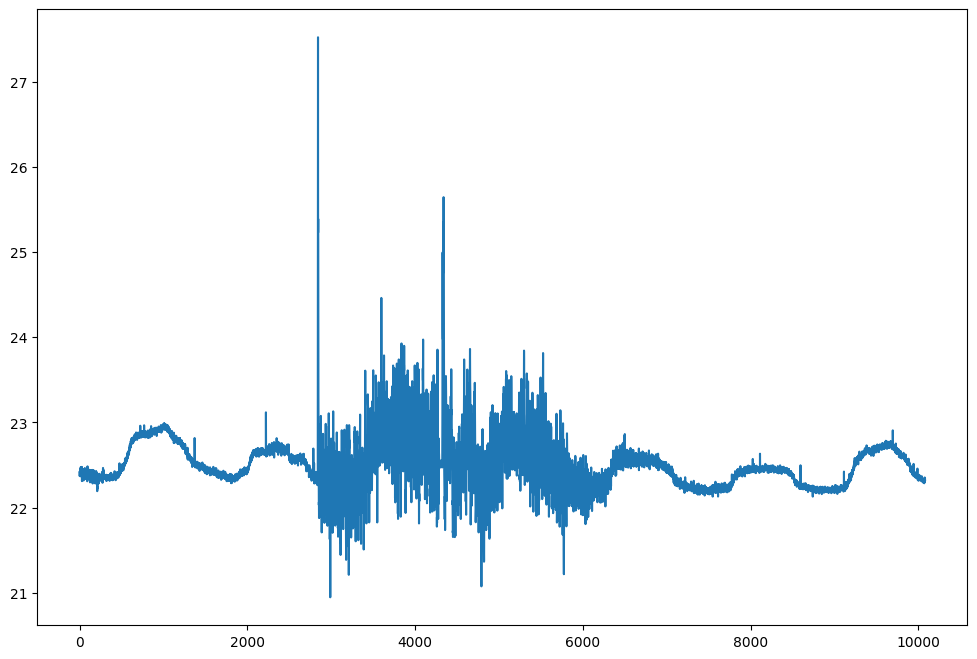

In [44]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')

In [46]:
len(pred_list)

10080

In [67]:
target = data.iloc[-split:]
target=list(target.values.reshape(-1,1))
score=SMAPE()(FloatTensor(list(np.array(pred_list).reshape(-1,1))),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.4622785747051239 %


In [60]:
pred_list

[22.411108016967773,
 22.36894416809082,
 22.42218589782715,
 22.42715072631836,
 22.414749145507812,
 22.418264389038086,
 22.412616729736328,
 22.392263412475586,
 22.409154891967773,
 22.453872680664062,
 22.40826988220215,
 22.408790588378906,
 22.431087493896484,
 22.473155975341797,
 22.398059844970703,
 22.374361038208008,
 22.396949768066406,
 22.446910858154297,
 22.40650749206543,
 22.432388305664062,
 22.473176956176758,
 22.361501693725586,
 22.40790367126465,
 22.434688568115234,
 22.411386489868164,
 22.436033248901367,
 22.367156982421875,
 22.47709083557129,
 22.310380935668945,
 22.432165145874023,
 22.413585662841797,
 22.402240753173828,
 22.414186477661133,
 22.41035270690918,
 22.433820724487305,
 22.393552780151367,
 22.363033294677734,
 22.433103561401367,
 22.444316864013672,
 22.381370544433594,
 22.423397064208984,
 22.393070220947266,
 22.44624137878418,
 22.40731430053711,
 22.372737884521484,
 22.45137596130371,
 22.43058967590332,
 22.317516326904297,
 22.

In [61]:
len(target)

10080

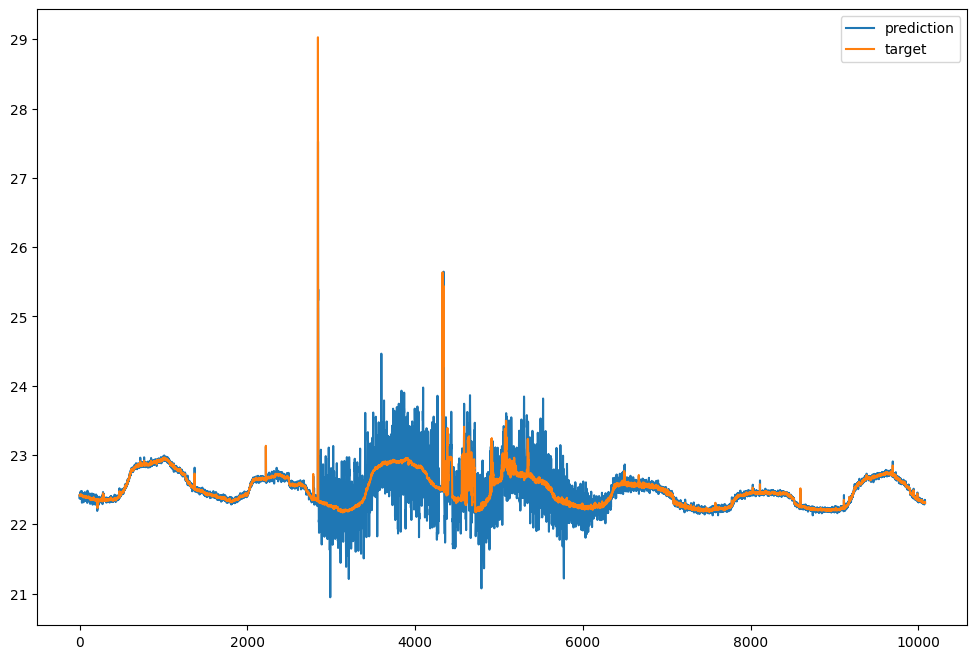

In [62]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

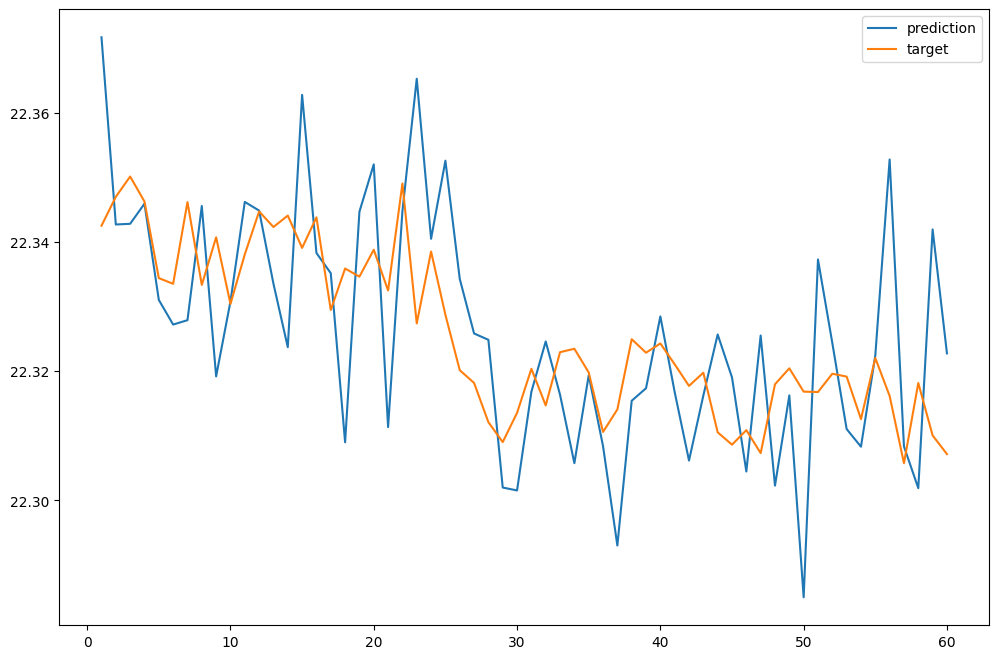

In [63]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

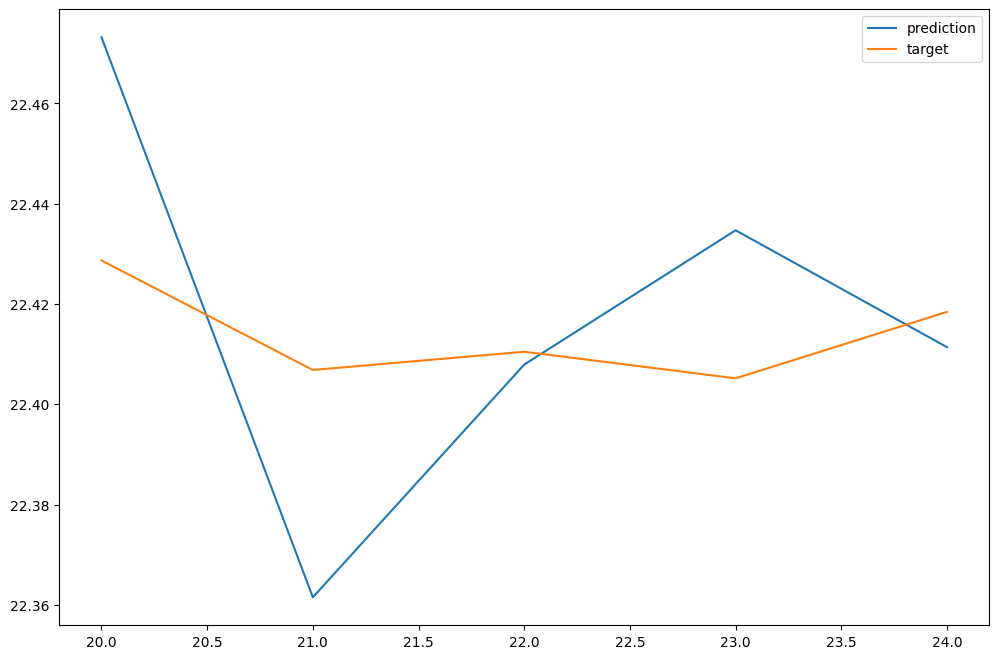

In [69]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(20,25),pred_list[20:25],label='prediction')
axes.plot(np.arange(20,25),target[20:25],label='target')
axes.legend()

In [64]:
np.mean(time_list)

0.8090833289046137

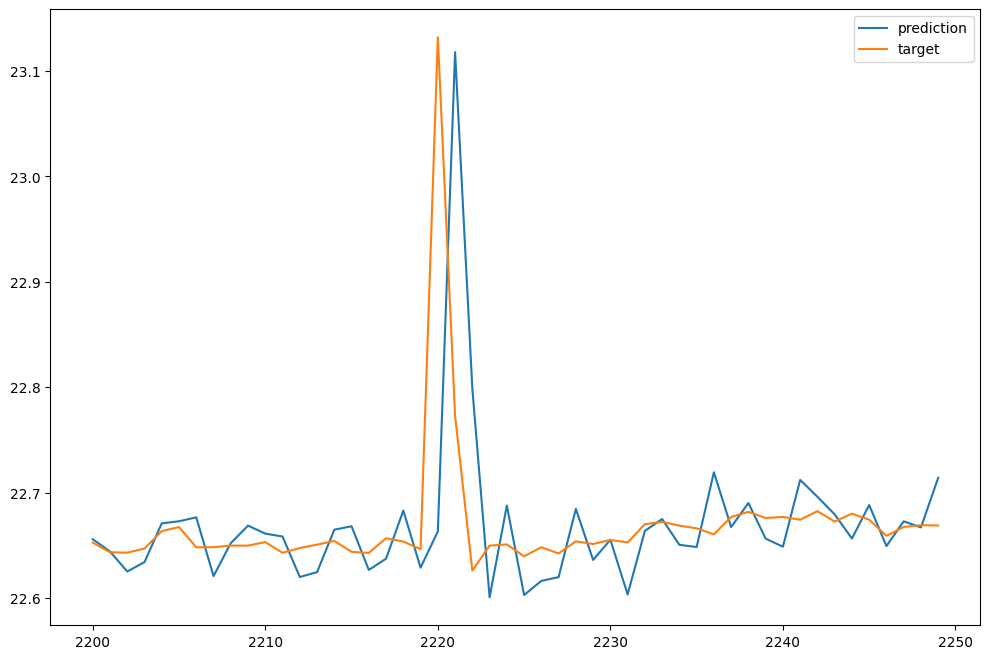

In [65]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()